In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from collections import Counter

In [2]:
# ==================== 1. 数据预处理 ====================
# 读取原始数据
raw_data = pd.read_excel('result_data.xlsx', header=None)


# 解析原始数据函数
def parse_data(raw):
    data = []
    current_date = None
    for row in raw.values:
        if len(str(row[0])) > 12:  # 时间戳行
            current_date = row[1].split(' ~ ')[0]
        elif isinstance(row[0], str):
            data.append({
                'date': current_date,
                'word': row[0].strip(),  # 增加strip处理
                'count': int(row[1])
            })
    return pd.DataFrame(data)


# 加载目标词
with open('target_words.txt', 'r', encoding='utf-8') as f:
    target_words = [w.strip() for w in f.readlines()]

# 生成原始数据框
df = parse_data(raw_data)
df

,date,word,count
0,2025-03-22 00:05:02,电动车,73
1,2025-03-22 00:05:02,道,22
2,2025-03-22 00:05:02,非机动车,31
3,2025-03-22 00:05:02,走,37
4,2025-03-22 00:05:02,人,116
...,...,...,...
4420,2024-10-05 00:05:02,允许,1
4421,2024-10-05 00:05:02,停车场,2
4422,2024-10-05 00:05:02,小哥,0
4423,2024-10-05 00:05:02,地铁,0


In [3]:
# ==================== 2. 高频词筛选 ====================
# 加载真实情感词典
with open('sentiment_dict.json', 'r', encoding='utf-8') as f:
    sentiment_dict = json.load(f)

# 统计总词频并优先选择有情感值的词
word_counts = df.groupby('word')['count'].sum().sort_values(ascending=False)
selected_words = [word for word in word_counts.index
                  if word in sentiment_dict.keys()][:100]  # 优化筛选逻辑

selected_words

['电动车',
 '人',
 '自行车',
 '非机动车',
 '道',
 '骑',
 '电动',
 '问题',
 '电鸡',
 '摩托车',
 '汽车',
 '外卖',
 '走',
 '限速',
 '广州',
 '车',
 '速度',
 '机动车',
 '应该',
 '人行道',
 '城市',
 '机动车道',
 '四轮',
 '快',
 '国标',
 '摩托',
 '跑',
 '知道',
 '限制',
 '停',
 '安全',
 '电瓶车',
 '道路',
 '需要',
 '驾照',
 '路',
 '管理',
 '禁',
 '逆行',
 '禁摩',
 '交通',
 '抓',
 '交警',
 '撞',
 '送',
 '电驴',
 '建议',
 '改装',
 '只能',
 '头盔',
 '行人',
 '牌',
 '开车',
 '解决',
 '两轮',
 '罚款',
 '路上',
 '事故',
 '太',
 '闯红灯',
 '根本',
 '上路',
 '车道',
 '电',
 '单车',
 '不用',
 '时速',
 '出行',
 '标准',
 '平台',
 '电摩',
 '不要',
 '规划',
 '禁止',
 '需求',
 '骑车',
 '规定',
 '支持',
 '时间',
 '视频',
 '违停',
 '罚',
 '死',
 '超速',
 '违法',
 '钱',
 '电车',
 '乱',
 '危险',
 '违规',
 '停车',
 '考驾照',
 '共享',
 '必须',
 '保险',
 '违章',
 '情况',
 '要求',
 '上班',
 '行驶']

In [4]:
# ==================== 3. 情感值计算 ====================
# 生成情感矩阵
def calculate_sentiment(pivot_df):
    sentiment_values = []
    for _, row in pivot_df.iterrows():
        total = 0
        for word in selected_words:
            # 严格匹配处理
            clean_word = word.strip().replace(" ", "")
            total += row[word] * sentiment_dict.get(clean_word, 0)
        sentiment_values.append(total)
    return np.array(sentiment_values)


# 构建数据管道
pivot_df = df.pivot(index='date', columns='word', values='count').fillna(0)
pivot_df = pivot_df[selected_words]  # 仅保留选定词
sentiment_series = calculate_sentiment(pivot_df)

# 归一化情感值（根据真实值域[-0.6054, 0.5269调整）
scaler = MinMaxScaler(feature_range=(-1, 1))
normalized_sentiment = scaler.fit_transform(sentiment_series.reshape(-1, 1))

In [5]:
# ==================== 4. 数据集构建 ====================
class SentimentDataset(Dataset):
    def __init__(self, data, time_steps=7):
        self.time_steps = time_steps
        self.X, self.y = self.create_sequences(data)

    def create_sequences(self, data):
        X, y = [], []
        for i in range(len(data) - self.time_steps):
            X.append(data[i:i + self.time_steps])
            y.append(data[i + self.time_steps])
        return torch.FloatTensor(np.array(X)), torch.FloatTensor(np.array(y))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# 参数设置
time_steps = 7  # 使用7天预测第8天
dataset = SentimentDataset(normalized_sentiment, time_steps)

# 划分数据集
train_size = int(0.8 * len(dataset))
train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [train_size, len(dataset) - train_size])

In [6]:
# ==================== 5. LSTM模型 ====================
class SentimentLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=64,
            
            batch_first=True
        )
        self.linear = nn.Sequential(
            nn.Linear(64, 1),
            nn.Tanh(),
            
        )
        

    def forward(self, x):
        x, _ = self.lstm(x)
        return self.linear(x[:, -1, :])


model = SentimentLSTM()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_fn = nn.MSELoss()


In [7]:
# ==================== 6. 训练过程 ====================
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

train_losses = []
val_losses = []

for epoch in range(30):
    # 训练阶段
    model.train()
    epoch_loss = 0
    for X, y in train_loader:
        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))
    

    # 验证阶段
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X, y in val_loader:
            y_pred = model(X)
            val_loss += loss_fn(y_pred, y).item()
    val_losses.append(val_loss / len(val_loader))
    

    print(f"Epoch {epoch + 1}/30 | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")

Epoch 1/30 | Train Loss: 0.2167 | Val Loss: 0.1538
Epoch 2/30 | Train Loss: 0.2106 | Val Loss: 0.1465
Epoch 3/30 | Train Loss: 0.2048 | Val Loss: 0.1394
Epoch 4/30 | Train Loss: 0.1993 | Val Loss: 0.1325
Epoch 5/30 | Train Loss: 0.1940 | Val Loss: 0.1258
Epoch 6/30 | Train Loss: 0.1889 | Val Loss: 0.1193
Epoch 7/30 | Train Loss: 0.1841 | Val Loss: 0.1129
Epoch 8/30 | Train Loss: 0.1795 | Val Loss: 0.1067
Epoch 9/30 | Train Loss: 0.1752 | Val Loss: 0.1008
Epoch 10/30 | Train Loss: 0.1713 | Val Loss: 0.0950
Epoch 11/30 | Train Loss: 0.1676 | Val Loss: 0.0895
Epoch 12/30 | Train Loss: 0.1643 | Val Loss: 0.0843
Epoch 13/30 | Train Loss: 0.1614 | Val Loss: 0.0795
Epoch 14/30 | Train Loss: 0.1590 | Val Loss: 0.0751
Epoch 15/30 | Train Loss: 0.1572 | Val Loss: 0.0712
Epoch 16/30 | Train Loss: 0.1560 | Val Loss: 0.0679
Epoch 17/30 | Train Loss: 0.1555 | Val Loss: 0.0654
Epoch 18/30 | Train Loss: 0.1555 | Val Loss: 0.0635
Epoch 19/30 | Train Loss: 0.1560 | Val Loss: 0.0622
Epoch 20/30 | Train L


情感词典覆盖率：100.0%


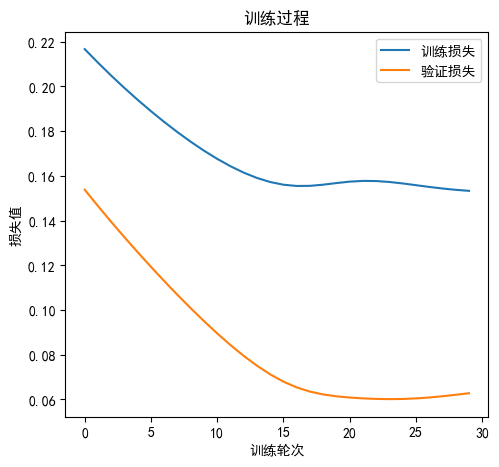

In [8]:
# ==================== 7. 可视化与验证 ====================
# 检查词典覆盖率
coverage = len([w for w in selected_words if w in sentiment_dict]) / len(selected_words)
print(f"\n情感词典覆盖率：{coverage:.1%}")

plt.rcParams['font.sans-serif'] = ['SimHei']
# 训练曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='训练损失')
plt.plot(val_losses, label='验证损失')
plt.title('训练过程')
plt.xlabel('训练轮次')
plt.ylabel('损失值')
plt.legend()



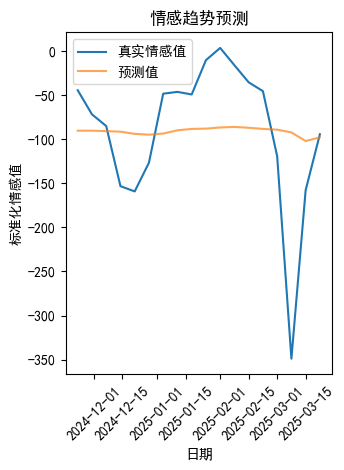

In [9]:
# 预测结果可视化
model.eval()
with torch.no_grad():
    all_X = torch.stack([x for x, _ in dataset])
    if len(all_X.shape) == 2:  # 如果是2D则添加时间步维度
     all_X = all_X.unsqueeze(1)
    all_pred = model(all_X).numpy().flatten()

    true_values = scaler.inverse_transform(dataset.y.numpy().reshape(-1, 1))
    pred_values = scaler.inverse_transform(all_pred.reshape(-1, 1))

# 日期处理
dates = pd.to_datetime(pivot_df.index[time_steps:])
plt.rcParams['axes.unicode_minus'] = False
plt.subplot(1, 2, 2)
plt.plot(dates, true_values, label='真实情感值')
plt.plot(dates, pred_values, label='预测值', alpha=0.7)
plt.title('情感趋势预测')
plt.xlabel('日期')
plt.ylabel('标准化情感值')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()